Random Forest
=======

In [26]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("ggplot")

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support, auc, accuracy_score

In [2]:
data = pd.read_csv("../data/loans_sample_processed.csv", sep = "^")

In [3]:
data.head()

,funded_amnt_inv,installment,int_rate,annual_inc,dti,total_rec_late_fee,total_acc,manager,refinance,term_ 36 months,...,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,application_type_Individual,application_type_Joint App,non_payment
0,25000.0,777.55,7.49,106157.0,9.37,0.00,49.0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,12000.0,404.27,12.99,67000.0,21.33,0.00,28.0,1,1,1,...,0,0,1,0,0,0,0,1,0,1
2,4800.0,175.59,18.85,56000.0,7.62,0.00,15.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
3,7900.0,273.82,14.99,58300.0,12.15,0.00,17.0,0,1,1,...,0,0,1,0,0,0,0,1,0,0
4,10725.0,385.43,17.57,36000.0,21.68,19.27,18.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0


In [4]:
data.shape

(49619, 38)

__Train / Test split:__

In [5]:
X = data.loc[:, data.columns!='non_payment']

In [6]:
y = data['non_payment']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4290)

__Prior__:

In [8]:
y.value_counts()[0] / len(y)

0.7968923194743949

__Random Forest__:

In [9]:
random_forest = RandomForestClassifier()

Grid Parameters:

In [90]:
rf_param_grid = {"max_depth": [10,50,100,500,1000],
                 "min_samples_leaf": [10,50,100,500,1000],
                 "n_estimators" :[10,50,100,500,1000]}

Cross validate model with Kfold stratified cross val

In [91]:
kfold = StratifiedKFold(n_splits=3)

In [92]:
gsRFC = GridSearchCV(random_forest, param_grid = rf_param_grid, cv = kfold, scoring = "roc_auc", n_jobs= 4, verbose = 1)

In [93]:
gsRFC.fit(X_train,y_train)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 13.4min
[Parallel(n_jobs=4)]: Done 375 out of 375 | elapsed: 24.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [10, 50, 100, 500, 1000], 'min_samples_leaf': [10, 50, 100, 500, 1000], 'n_estimators': [10, 50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [94]:
gsRFC.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [95]:
gsRFC.best_score_

0.7232013061702446

Feature importance:

Text(0.5,1,'Feature importance')

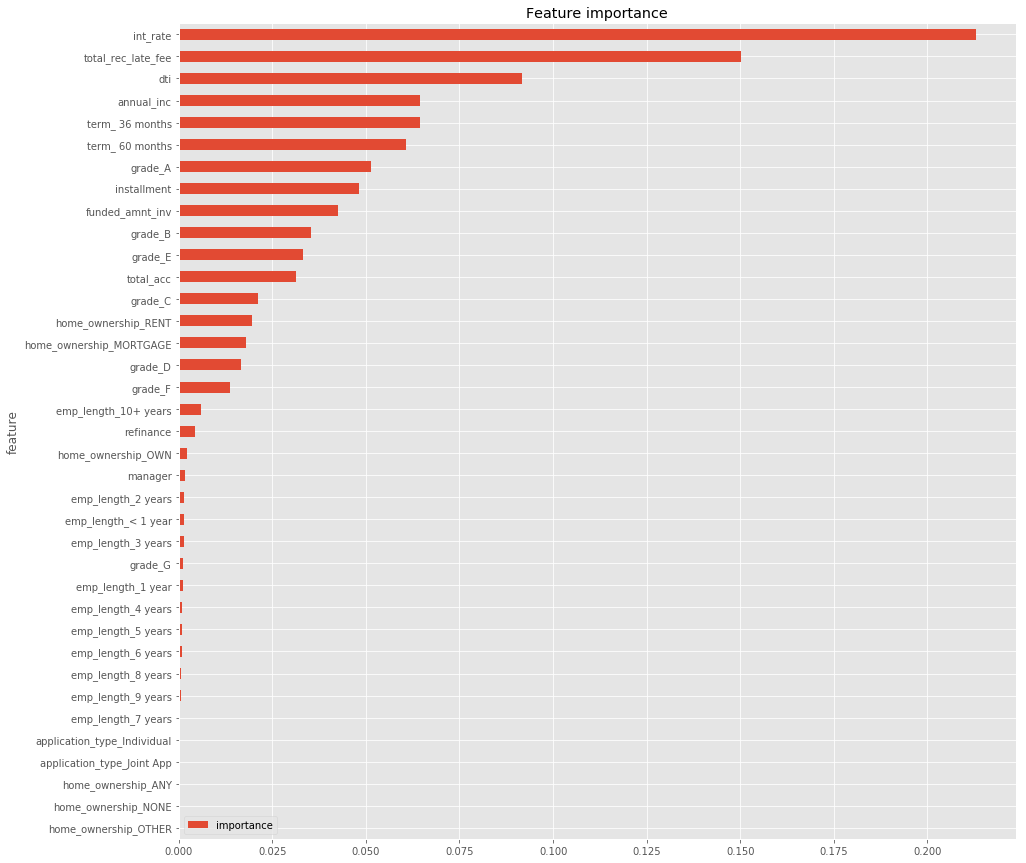

In [96]:
features = pd.DataFrame({'feature':X_train.columns,
                         'importance':gsRFC.best_estimator_.feature_importances_})

features = features.set_index('feature').sort_values('importance', ascending=True)

features.plot(kind='barh',figsize=(15,15)).set_title('Feature importance')

In [97]:
random_forest = RandomForestClassifier(max_depth=10, n_estimators=200,  min_samples_leaf=25)

In [98]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

__Model Evaluation__

AUC in the train set:

In [99]:
y_scores_train = random_forest.predict_proba(X_train)

y_scores_train = pd.DataFrame(y_scores_train).loc[:,1]

In [100]:
roc_auc_score(y_train, y_scores_train)

0.7546285497876475

ROC Curve:

In [101]:
y_scores = random_forest.predict_proba(X_test)

y_scores = pd.DataFrame(y_scores).loc[:,1]

In [102]:
fpr, tpr, _ = roc_curve(y_test, y_scores)

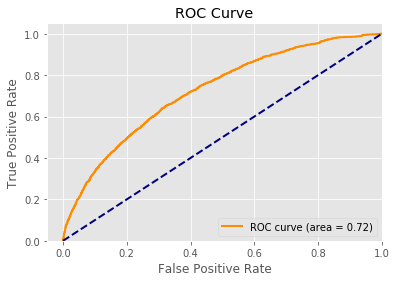

In [103]:
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

AUC:

In [104]:
roc_auc_score(y_test, y_scores)

0.7248590774661893

Confusion Matrix

In [105]:
y_predictions = gsRFC.best_estimator_.predict(X_test)

In [106]:
confusion_matrix(y_test, y_predictions)

array([[7853,   70],
       [1865,  136]])

Accuracy:

In [107]:
accuracy_score(y_test, y_predictions)

0.8050181378476421

Recall:

In [108]:
precision_recall_fscore_support(y_test, y_predictions) [0]

array([0.80808808, 0.66019417])

Precision:

In [109]:
precision_recall_fscore_support(y_test, y_predictions) [1]

array([0.99116496, 0.06796602])